In [1]:
# Loading required packages
import bambi as bmb
import scipy as sp
import numpy as np
import arviz as az
import polars as pl
import plotnine as p9
import matplotlib.pyplot as plt

In [20]:
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

Generator(PCG64) at 0x11DD3BE60

# Simulating data

One method for validating proposed models is to generate a known dataset and then fit your model to the given dataset. If we observe difficulties fitting the model we need to reconsider the parameterisation or the priors.

## Experiment
Given that there are two strains we want characterise the amount of protein each cell line produced. We have access to sets of reactors to perform this experiment, and the protein concentrations will be measured using mass spectroscopy that has a log-normal measurement model.

### Notes
- Often we want to make statements about strains rather than reactors.
- If we assume that the reactor to reactor variation is the same between strains then we are able to improve our fits using a heirarchical modelling approach called "partial pooling",

In [523]:
# Generating the dataset
strain_growth_array = [0.49, 0.51, 0.53, 0.55, 0.57]
sigma_reactor_effect = 0.03
sigma_quant = 0.01
n_reactors = 4
protein_measurements = { strain:
    [float(np.exp(np.log(strain_growth_array[strain]) + np.random.normal(0, sigma_reactor_effect))) for _ in range(n_reactors)]
                    for strain, _ in enumerate(strain_growth_array)
}

In [538]:
protein_measurements

{0: [0.47473160053777713,
  0.5155596293913945,
  0.48872967810845125,
  0.46717435660797463],
 1: [0.4921955163052041,
  0.4894796958555226,
  0.48893083375215024,
  0.4999988155712595],
 2: [0.53301473264724,
  0.5386334786744309,
  0.5385975589002475,
  0.529187760792642],
 3: [0.543502953972827,
  0.55974907666733,
  0.5498033054848962,
  0.5637436207630534],
 4: [0.5698282718432269,
  0.5419945580231189,
  0.5470631922017978,
  0.5987330965059178]}

# Preprocessing Data

In [539]:
reactor_count = 0
raw_data = []
for strain, _ in enumerate(strain_growth_array):
    for reactor, _ in enumerate(protein_measurements[strain]):
        raw_data.append(
        {
            "strain": strain,
            "reactor": reactor_count,
            "prot": np.log(protein_measurements[strain][reactor] + np.random.normal(0,1)*sigma_quant),
        }
            )
        reactor_count+=1
    

In [540]:
data = pl.from_dicts(raw_data)
data

strain,reactor,prot
i64,i64,f64
0,0,-0.758058
0,1,-0.648138
0,2,-0.719155
0,3,-0.738148
1,4,-0.733641
…,…,…
3,15,-0.585648
4,16,-0.57612
4,17,-0.633572


In [544]:
data.filter(pl.col("strain")==0)

strain,reactor,prot
i64,i64,f64
0,0,-0.758058
0,1,-0.648138
0,2,-0.719155
0,3,-0.738148


# T-test

In [545]:
sp.stats.ttest_ind(data.filter(pl.col("strain")==0)["prot"], data.filter(pl.col("strain")==1)["prot"], equal_var=True)

TtestResult(statistic=np.float64(-0.18788528631771015), pvalue=np.float64(0.857159693180108), df=np.float64(6.0))

# Statistical model
The model we are trying to fit in this instance is as follows
$$\mu_{reactor} \sim LogNormal(\mu_{true, reactor}, \sigma_{quant})$$
$$\mu_{true, reactor} \sim LogNormal(\mu_{true, strain}, \sigma_{biological})$$

With priors
$$\sigma_{quant} \sim log_normal(log(0.01), 0.1)$$
$$\sigma_{biological} \sim HalfNormal(0.03)$$


In [533]:
priors = {
    "sigma": bmb.Prior("LogNormal", mu=np.log(sigma_od), sigma=0.1),       # measurement error
    "1|reactor_sigma": bmb.Prior("HalfNormal", sigma=sigma_reactor_effect),
}

model = bmb.Model(
    "prot ~ 0 + strain + (0 + 1|reactor)",
    data=data.to_pandas(),
    categorical=["strain", "reactor"],
    priors=priors,
    noncentered=True
)
model.build()
model.graph()
results = model.fit(tune=2000, nuts_sampler_kwargs={"target_accept": 0.9})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, strain, 1|reactor_sigma, 1|reactor_offset]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

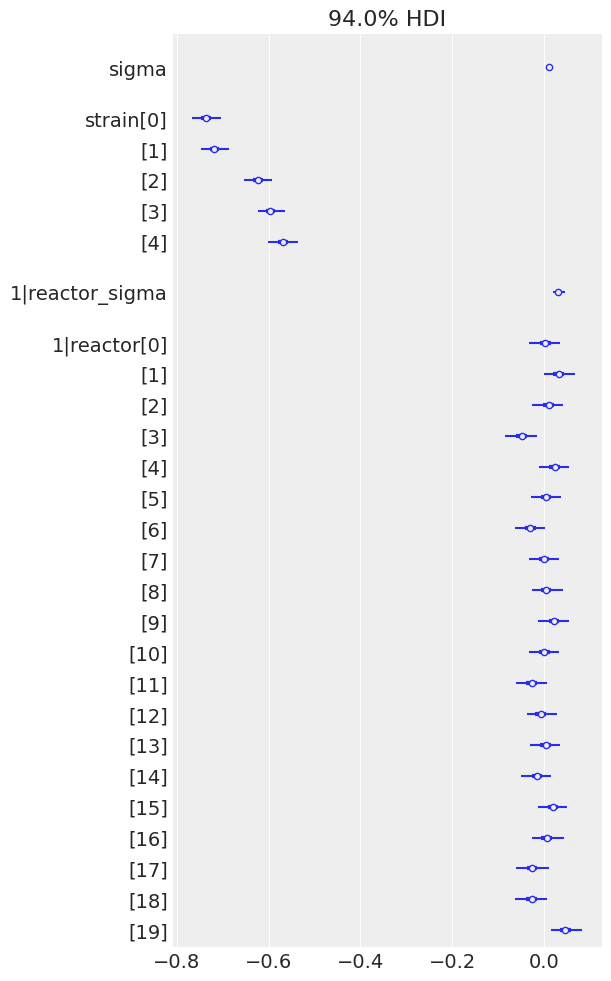

In [534]:
az.plot_forest(results.sel(data_var=["strain"]), combined=True)

(array([1.000e+00, 1.000e+00, 1.600e+01, 1.250e+02, 7.180e+02, 1.764e+03,
        1.106e+03, 2.370e+02, 3.000e+01, 2.000e+00]),
 array([-0.23563336, -0.21059634, -0.18555933, -0.16052231, -0.13548529,
        -0.11044828, -0.08541126, -0.06037425, -0.03533723, -0.01030021,
         0.0147368 ]),
 <BarContainer object of 10 artists>)

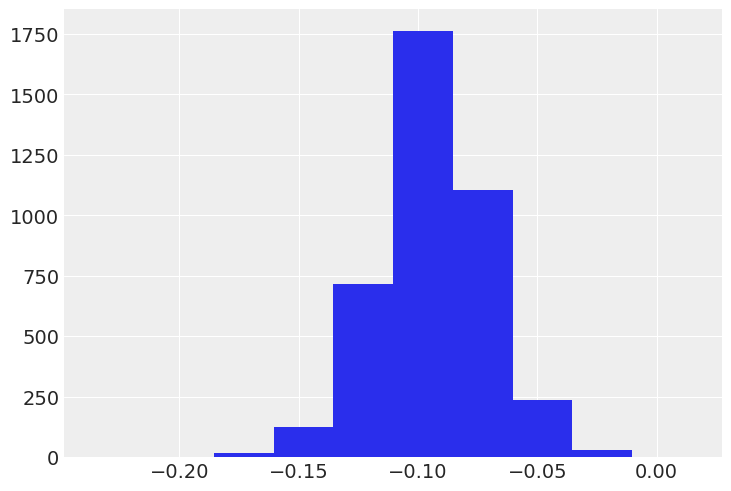

In [535]:
diff = results.posterior.strain.sel(strain_dim = ["1"]).values.flatten() - results.posterior.strain.sel(strain_dim = ["2"]).values.flatten()
fig, ax = plt.subplots(1,1)
ax.hist(diff)

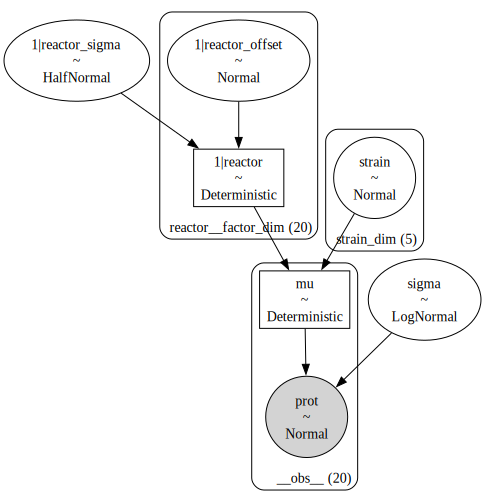

In [531]:
model.graph()